In [66]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [144]:
import folder_handling as fh

reload(fh)

<module 'folder_handling' from 'folder_handling.py'>

In [68]:
#path_to_raw_photo = "../../images/color_experiments/experiment_2/raw_photo"
#fh.compress_photos(path_to_raw_photo)
path_compressed = "../../images/color_experiments/experiment_2/compressed/"

In [69]:
exp = fh.Experiment()

In [70]:
exp.load_images(path_compressed,char_to_split_color_name=".")

Отобразим сжатые изображения.

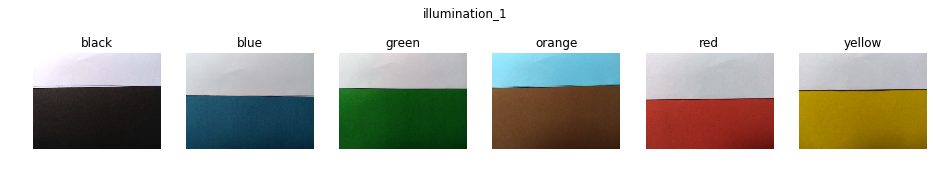

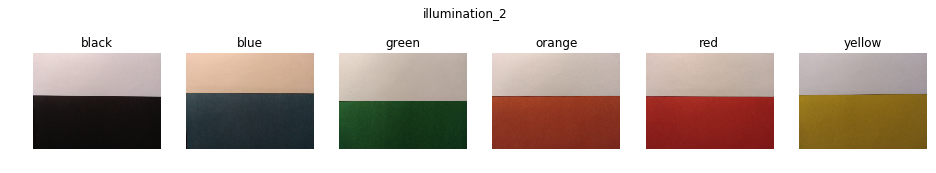

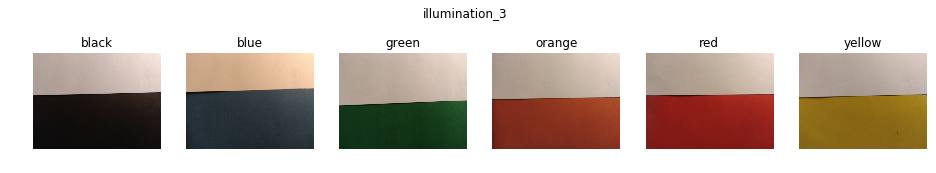

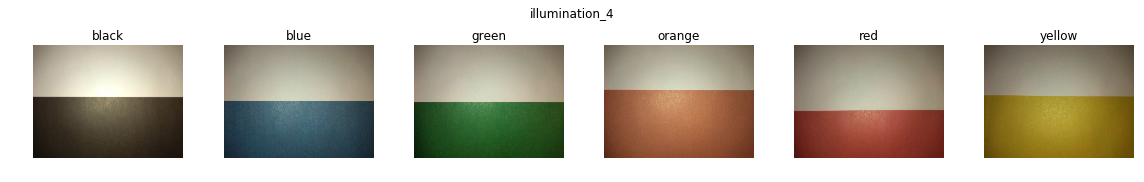

In [71]:

for name,Illum in sorted(exp.illuminations.iteritems()):
    plt.figure(figsize=(16,6))
    
    for i,color in enumerate(Illum.images):
        n_colors = len(Illum.images)
        plt.subplot(1,n_colors,i+1)
        img = Illum.images[color][0]
        plt.imshow(img)
        plt.title(color)
        plt.axis('off')
    plt.suptitle(Illum.name,x=0.5,y=0.72)
plt.tight_layout()

Отлично, все фотографии выглядят более-менее одинаково (ничего не надо разворачивать). 

Попробуем по верхней части (четверти, для начала), оценить баланс белого на фотографии, чтобы подтянуть все каналы

In [118]:
def get_white_part(img,n=4):
    return img[:img.shape[0]//n,:,:]

def get_nonwhite_part(img,n=4):
    return img[-img.shape[0]//n:,:,:]

def compute_rw_gw_bw(img_w):
    rw,gw,bw = img_w.mean(axis=(0,1))
    
    return rw,gw,bw

In [235]:
adjusted_images = {} # color: list of images of same 
raw_images = {}
print "Check to preserve order"
for name,illum in sorted(exp.illuminations.iteritems()):
    
    print "Adding image from ", name
    for color in illum.images:
        img = illum.images[color][0]
        
        if color not in adjusted_images:
            adjusted_images[color] = []
            raw_images[color] = []
        img_w = get_white_part(img)
        img_nw = get_nonwhite_part(img)
        colors_w = compute_rw_gw_bw(img_w)
        adj_img = fh.adjust_white_balance_wrt_rgb(img_nw,colors_w)
        
        
        adjusted_images[color].append(adj_img)
        raw_images[color].append(img_nw) 

Check to preserve order
Adding image from  illumination_1
Adding image from  illumination_2
Adding image from  illumination_3
Adding image from  illumination_4


Выведем скорректированные по балансу белого изображения

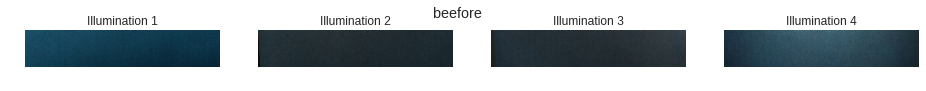

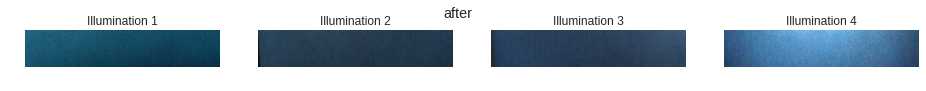

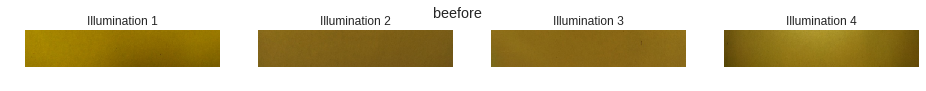

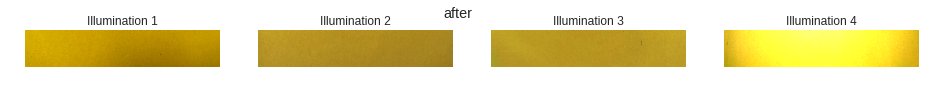

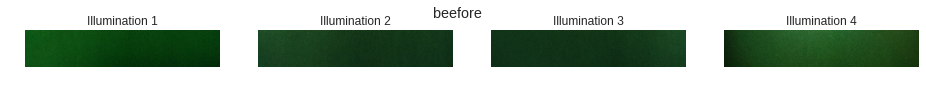

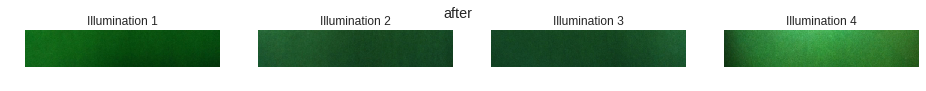

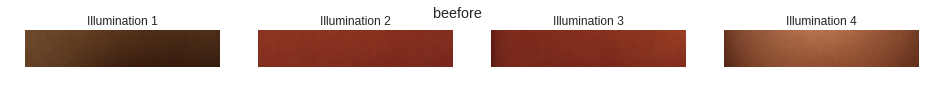

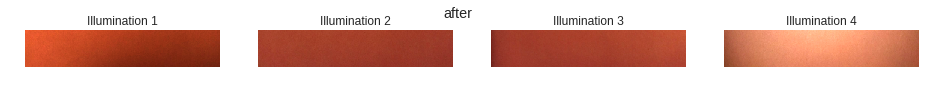

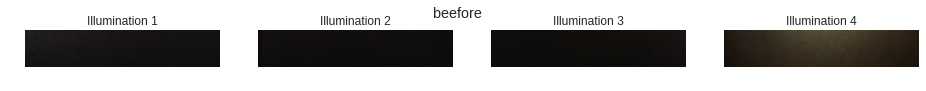

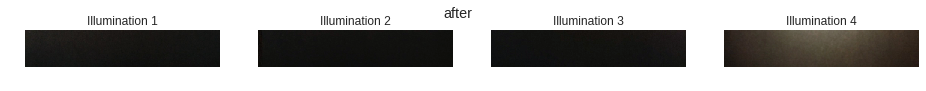

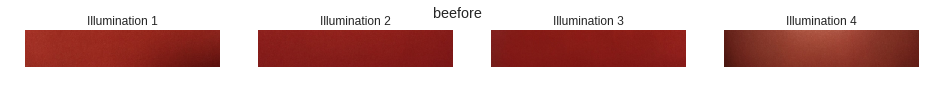

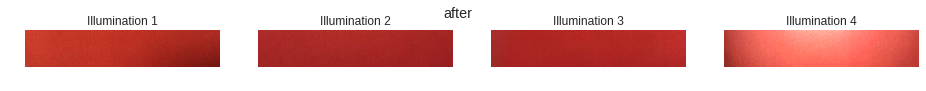

In [238]:
for color in adjusted_images:
    n_images = len(adjusted_images[color])
    plt.figure(figsize=(16,6))
    
    for i,img in enumerate(raw_images[color]):
        plt.subplot(1,n_images,i+1)
        plt.imshow(img)
        plt.title('Illumination {}'.format(i+1))
        plt.axis('off')
    plt.suptitle("beefore",x=0.5,y=0.6)
    plt.figure(figsize=(16,6))
    
    for i,img in enumerate(adjusted_images[color]):
        plt.subplot(1,n_images,i+1)
        
        plt.imshow(img)
        plt.title('Illumination {}'.format(i+1))
        plt.axis('off')
    plt.suptitle("after",x=0.5,y=0.6)

Посмотрим на гистограммы распределений цвета на скорректированных изображениях с различным освещением

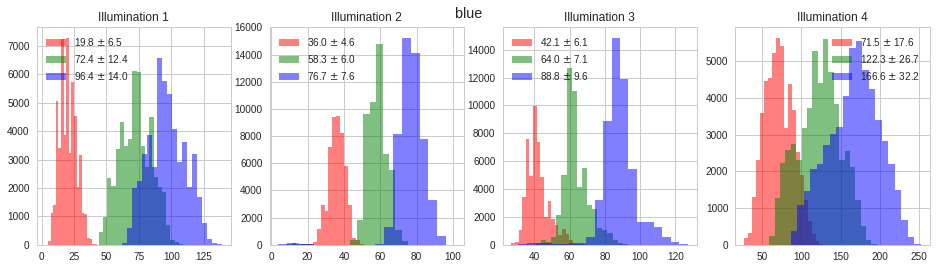

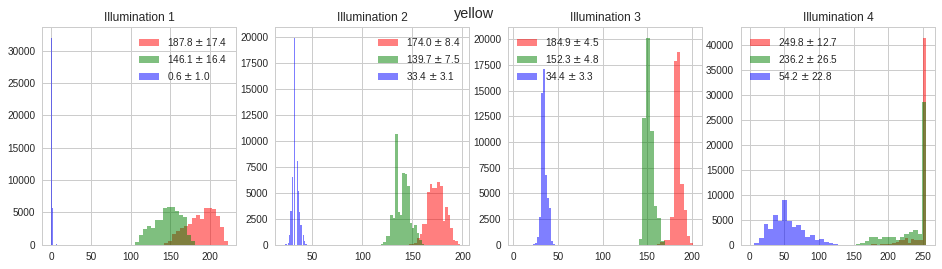

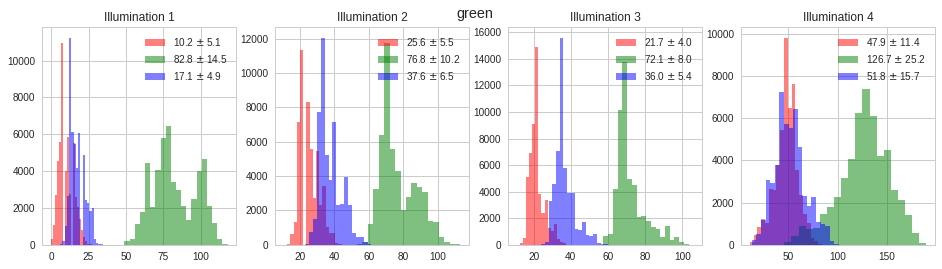

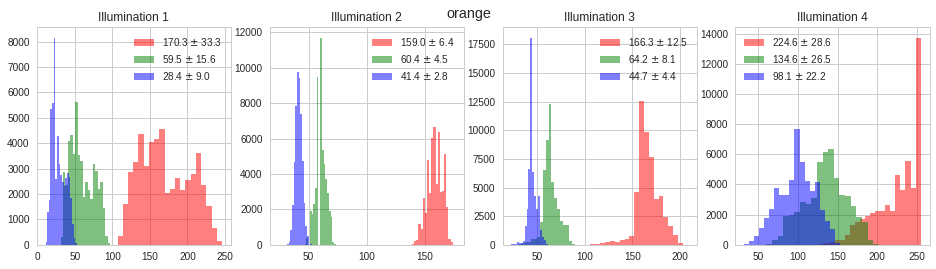

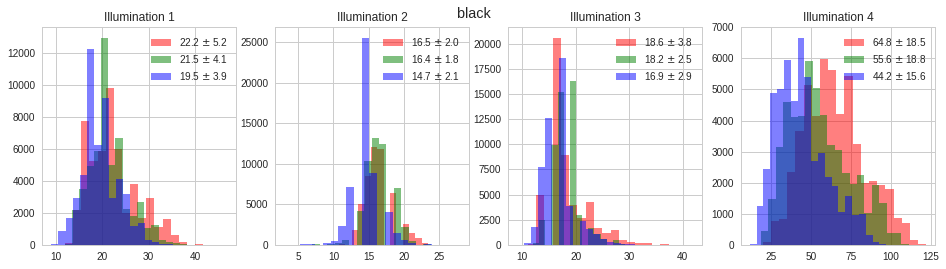

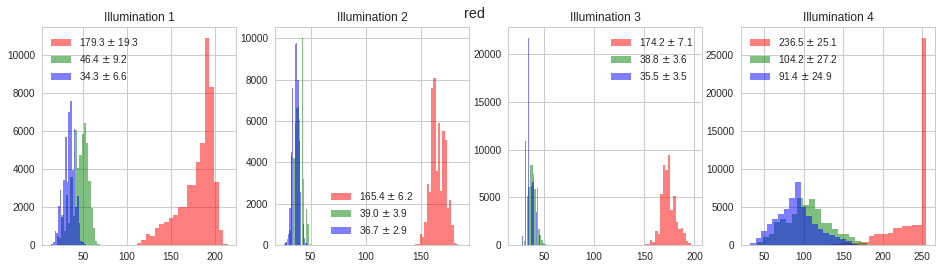

In [239]:
for color in adjusted_images:
    n_images = len(adjusted_images[color])
    plt.figure(figsize=(16,4))
    
    for i,img in enumerate(adjusted_images[color]):
        plt.subplot(1,n_images,i+1)
        
        fh.plot_color_hist(img)
        plt.title('Illumination {}'.format(i+1))
        plt.legend()
    plt.suptitle(color,x=0.5,y=0.95)

In [240]:
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')

In [243]:

color_dataframes = {}

for color in adjusted_images:
    
    data = pd.DataFrame(columns=["val","channel","illumination"])
    for i,img in enumerate(adjusted_images[color][:-1]):
        r_val = np.ravel(img[:,:,0])
        g_val = np.ravel(img[:,:,1])
        b_val = np.ravel(img[:,:,2])
        r_name = np.array(['r']*r_val.shape[0])
        g_name = np.array(['g']*g_val.shape[0])
        b_name = np.array(['b']*b_val.shape[0])
        raveled_img = np.hstack((r_val,g_val,b_val))
        channel_name = np.hstack((r_name,g_name,b_name))

        illum = np.array(['illum_{}'.format(i+1)]*raveled_img.shape[0])
        data2 = pd.DataFrame({"val":raveled_img,
                     "channel":channel_name,
                     "illumination":illum})
        
        data = data.append(data2,ignore_index=True)
        
    color_dataframes[color] = data

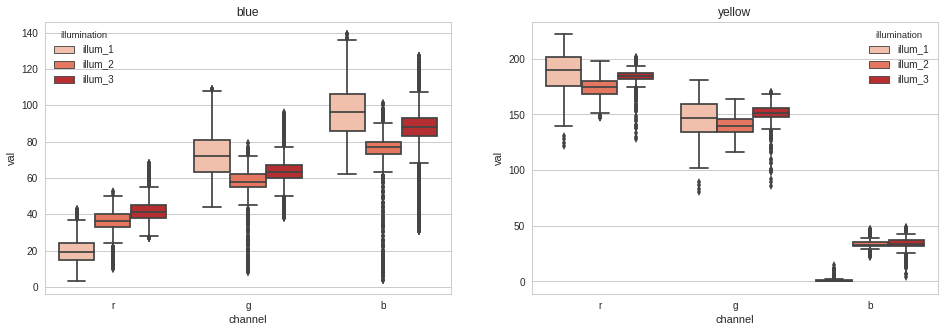

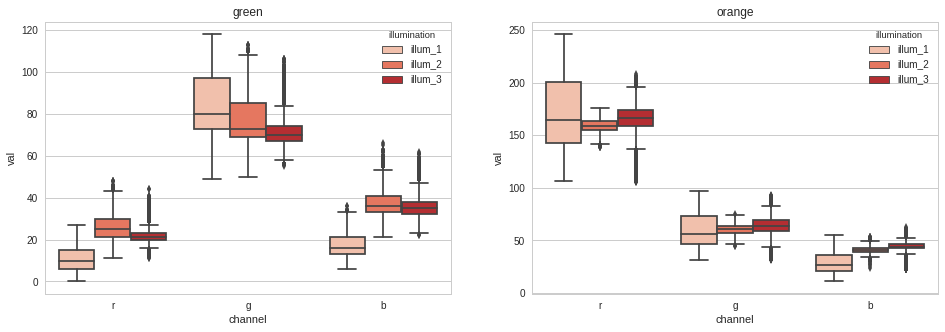

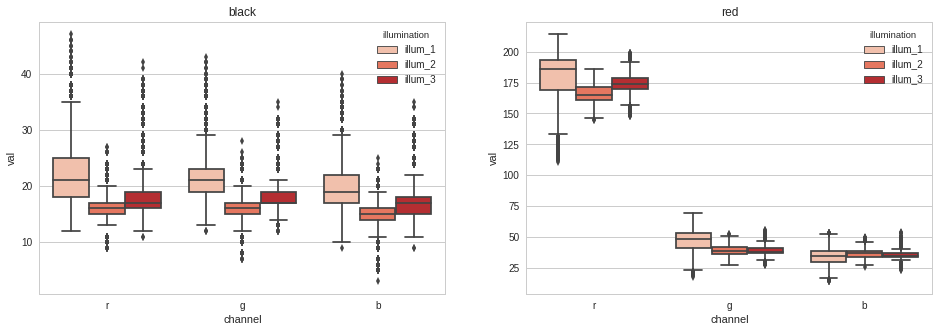

In [244]:
n_colors = len(color_dataframes)

for i,color in enumerate(color_dataframes):
    
    if i%2 == 0:
        plt.figure(figsize=(16,5))
    plt.subplot(1,2,i%2 + 1)
    sns.boxplot(x="channel",y="val",hue="illumination",palette="Reds",data=color_dataframes[color])
    plt.title(color)

Сравним распределение величин в каналах между "сырыми" и "скорректированными" изображениямиэ

In [251]:
color_dataframes_raw = {}

for color in adjusted_images:
    
    data = pd.DataFrame(columns=["val","channel","illumination"])
    for i,img in enumerate(raw_images[color][:-1]):
        r_val = np.ravel(img[:,:,0])
        g_val = np.ravel(img[:,:,1])
        b_val = np.ravel(img[:,:,2])
        r_name = np.array(['r']*r_val.shape[0])
        g_name = np.array(['g']*g_val.shape[0])
        b_name = np.array(['b']*b_val.shape[0])
        raveled_img = np.hstack((r_val,g_val,b_val))
        channel_name = np.hstack((r_name,g_name,b_name))

        illum = np.array(['illum_raw_{}'.format(i+1)]*raveled_img.shape[0])
        data2 = pd.DataFrame({"val":raveled_img,
                     "channel":channel_name,
                     "illumination":illum})
        
        data = data.append(data2,ignore_index=True)
        
    color_dataframes_raw[color] = data

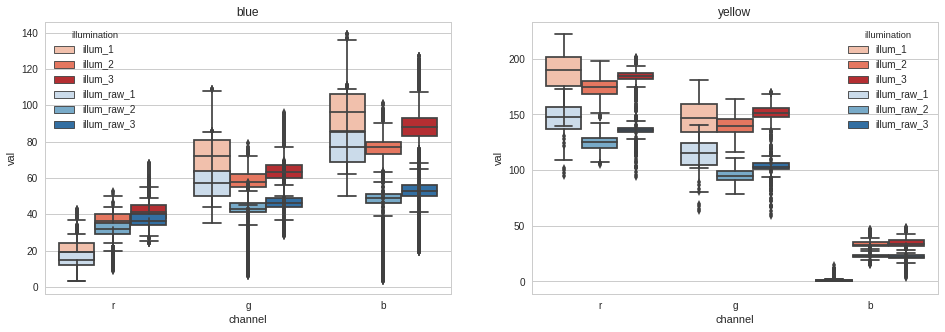

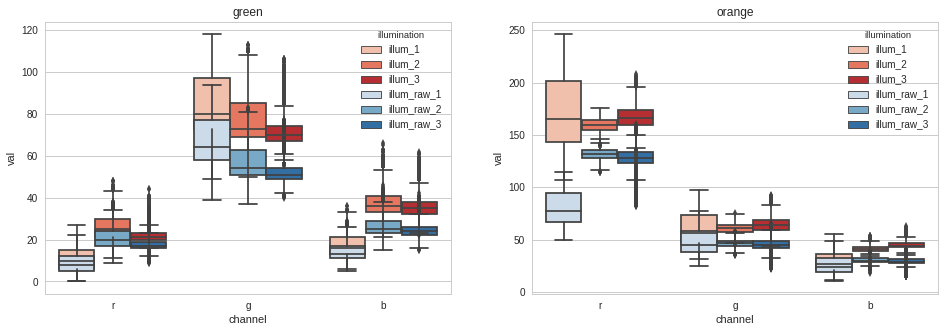

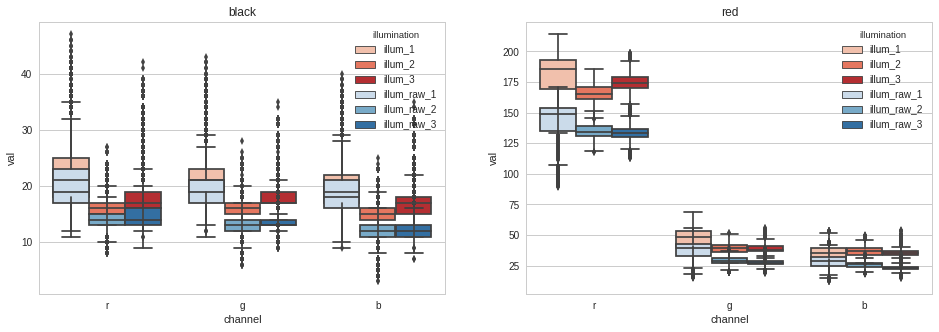

In [255]:
n_colors = len(color_dataframes)

for i,color in enumerate(color_dataframes):
    
    if i%2 == 0:
        plt.figure(figsize=(16,5))
    plt.subplot(1,2,i%2 + 1)
    sns.boxplot(x="channel",y="val",hue="illumination",palette="Reds",data=color_dataframes[color],saturation=0.75)
    sns.boxplot(x="channel",y="val",hue="illumination",palette="Blues",data=color_dataframes_raw[color])
    plt.title(color)